Benchmark of 4 feature selection techniques: HSIC Lasso, Block HSIC Lasso, mRMR and LARS. For each of the methods, the way to select features was different:

- mRMR and LARS are asked to select the best 4 features.
- (Baby) HSIC Lasso is asked to select 50 features. All 50 are used for the regression, but only the top 4 are considered for feature selection evaluation. Baby HSIC lasso instances run 3 permutations to reduce the estimator sampling error.

In [1]:
library(tidyverse)
library(cowplot)

palette <- c('HSIC Lasso' = '#c994c7', 'HSIC Lasso, B = 50' = '#df65b0',
             'HSIC Lasso, B = 20' = '#e7298a', 'HSIC Lasso, B = 10' = '#ce1256',
             'HSIC Lasso, B = 5' = '#67001f',
             'LARS' = '#2171b5', 'mRMR' = '#238443')
methods <- c('HSIC Lasso', 'HSIC Lasso, B = 50',
             'HSIC Lasso, B = 40','HSIC Lasso, B = 30',
             'HSIC Lasso, B = 20','HSIC Lasso, B = 10',
             'HSIC Lasso, B = 5', 'mRMR', 'LARS')
samples <-  c('100 samples', '1000 samples', '10000 samples')
fct_feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')
fct_causal <- c('5 causal', '10 causal', '20 causal')

prepare_df <- function(x) {
    mutate(x,
           model = gsub('HSIC_lasso', 'HSIC Lasso', model),
           model = gsub('-B=0', '', model),
           model = gsub('-B=', ', B = ', model),
           model = gsub('-M=3', '', model),
           model = factor(model, levels = methods),
           samples_txt = factor(paste(samples, 'samples')),
           causal_txt = factor(paste(causal, 'causal'), levels = fct_causal),
           features_txt = factor(paste(features, 'features'), levels = fct_feats)) %>%
    group_by(model, samples, features, causal, samples_txt, features_txt, causal_txt) 
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



# Data simulated as in Yamada *et al.*

## Additive model

The outcome is generated as

$$y=2 sin(2 x_1) + x_2^2 + x_3 + exp(-x_4) + \varepsilon$$

where $\varepsilon ~ N(0,1)$. The script is available [here](../scripts/templates/analysis/yamada_additive.py).

In [2]:
# Feature selection measures
ya_features <- read_tsv('../results/benchmark/yamada_additive_feature_selection.tsv', 
                        col_types = 'ciiiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(tpr)),
              sem = sd(tpr) / sqrt(ended), tpr = mean(tpr),
              selected = mean(selected)) %>%
    ungroup

# Regression measures
ya_prediction <- read_tsv('../results/benchmark/yamada_additive_prediction.tsv', 
                       col_types = 'ciiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(mse)),
              sem = sd(mse) / sqrt(ended), mse = mean(mse) ) %>%
    ungroup

Warning message:
“Removed 3 rows containing missing values (geom_errorbar).”Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 3 rows containing missing values (geom_path).”

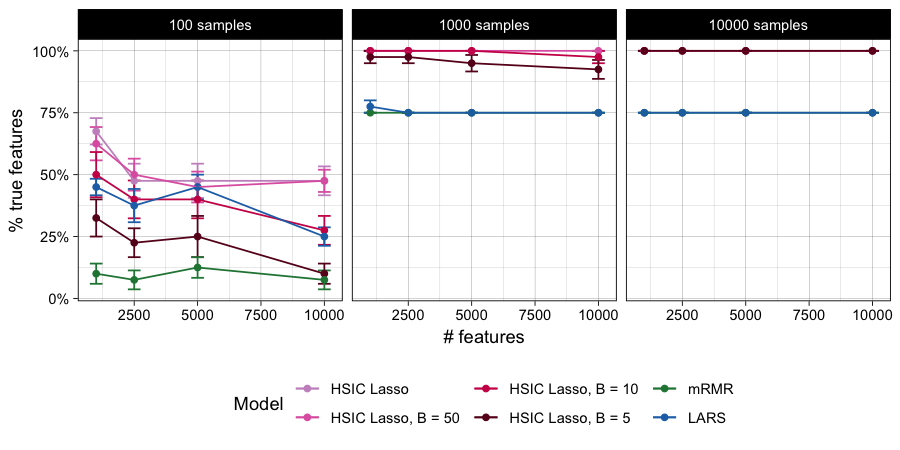

In [3]:
options(repr.plot.width=7.5, repr.plot.height=3.75)
ggplot(ya_features, aes(x = features, y = tpr, color = model)) +
    geom_errorbar(aes(ymin = tpr - sem, ymax = tpr + sem), width = 500) +
    geom_point() +
    geom_line() +
    theme_linedraw() +
    theme(legend.position = 'bottom') +
    labs(x = '# features', y = '% true features', color = 'Model') +
    facet_grid(. ~ samples_txt) + 
    scale_y_continuous(labels = scales::percent) +
    scale_color_manual(values = palette)

Warning message:
“Removed 3 rows containing missing values (geom_errorbar).”Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

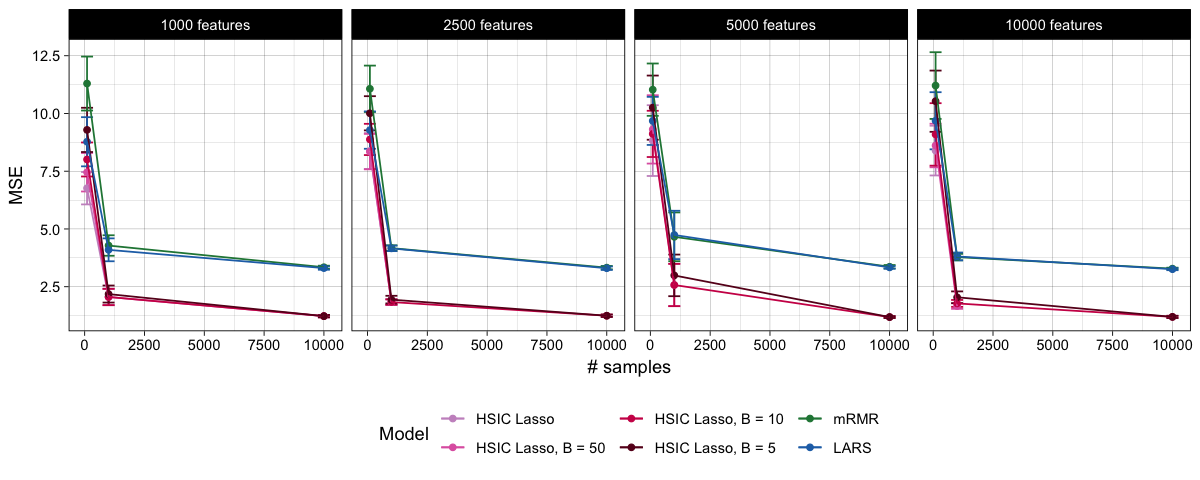

In [4]:
options(repr.plot.width=10, repr.plot.height=4)
ya_prediction %>%
    ggplot(aes(x = samples, y = mse, color = model)) +
        geom_errorbar(aes(ymin = mse - sem, ymax = mse + sem), width = 500) +
        geom_point() +
        geom_line() +
        theme_linedraw() +
        theme(legend.position = 'bottom') +
        labs(x = '# samples', y = 'MSE', color = 'Model') +
        facet_grid(. ~ features_txt) +
        scale_color_manual(values = palette)

## Non-additive model

The outcome is generated as

$$y = x_1  exp(2x_2) + x_3^2 + \varepsilon$$

where $\varepsilon ~ N(0,1)$. The script is available [here](../scripts/templates/analysis/yamada_nonadditive.py).

In [5]:
# Feature selection measures
yn_features <- read_tsv('../results/benchmark/yamada_nonadditive_feature_selection.tsv', 
                        col_types = 'ciiiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(tpr)),
              sem = sd(tpr) / sqrt(ended), tpr = mean(tpr),
              selected = mean(selected)) %>%
    ungroup

# Regression measures
yn_prediction <- read_tsv('../results/benchmark/yamada_nonadditive_prediction.tsv', 
                       col_types = 'ciiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(mse)),
              sem = sd(mse) / sqrt(ended), mse = mean(mse) ) %>%
    ungroup

Warning message:
“Removed 3 rows containing missing values (geom_errorbar).”Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 3 rows containing missing values (geom_path).”

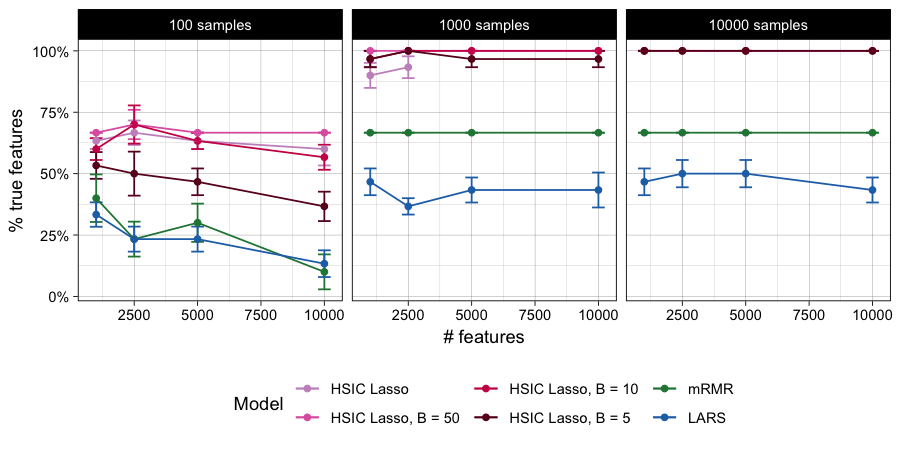

In [6]:
options(repr.plot.width=7.5, repr.plot.height=3.75)
ggplot(yn_features, aes(x = features, y = tpr, color = model)) +
    geom_errorbar(aes(ymin = tpr - sem, ymax = tpr + sem), width = 500) +
    geom_point() +
    geom_line() +
    theme_linedraw() +
    theme(legend.position = 'bottom') +
    labs(x = '# features', y = '% true features', color = 'Model') +
    facet_grid(. ~ samples_txt) + 
    scale_y_continuous(labels = scales::percent) +
    scale_color_manual(values = palette)

Warning message:
“Removed 3 rows containing missing values (geom_errorbar).”Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_path).”

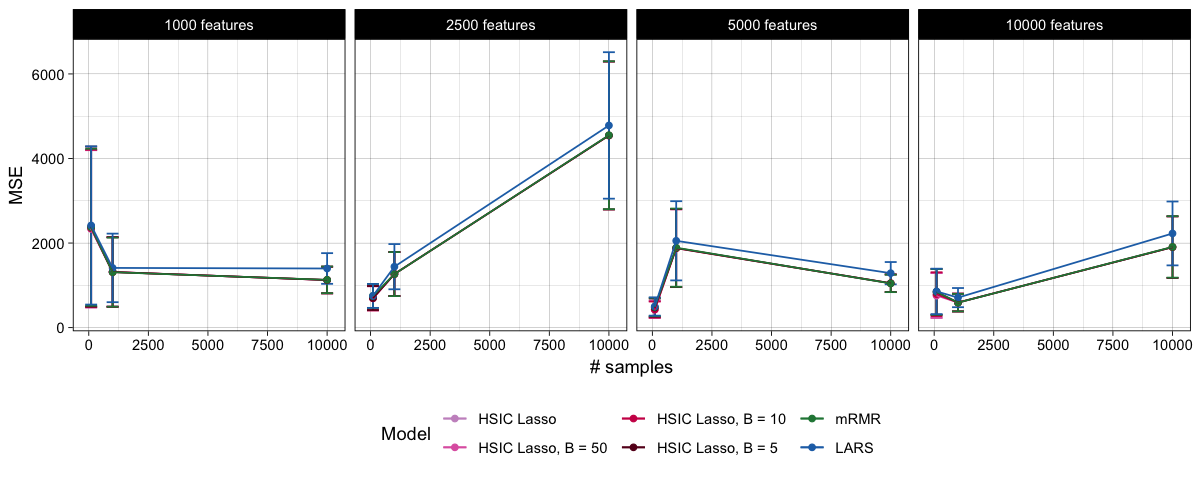

In [7]:
options(repr.plot.width=10, repr.plot.height=4)
yn_prediction %>%
    ggplot(aes(x = samples, y = mse, color = model)) +
        geom_errorbar(aes(ymin = mse - sem, ymax = mse + sem), width = 500) +
        geom_point() +
        geom_line() +
        theme_linedraw() +
        theme(legend.position = 'bottom') +
        labs(x = '# samples', y = 'MSE', color = 'Model') +
        facet_grid(. ~ features_txt) +
        scale_color_manual(values = palette)

# In-house generated data

For different combinations we generated synthetic data of varying numbers of samples (100, 1000, 10000) and numbers of features (1000, 2500, 5000, 10000). Applying the above methods, we tried to recover the original causal features. For each experimental condition, we generated 10 replicates. The data-generating script is available [here](../scripts/templates/data_processing/generate_data.py).

In [8]:
# Feature selection measures
features <- read_tsv('../results/benchmark/random_feature_selection.tsv', 
                     col_types = 'ciiiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(tpr)),
              sem = sd(tpr) / sqrt(ended), tpr = mean(tpr),
              selected = mean(selected)) %>%
    ungroup

# Regression measures
prediction <- read_tsv('../results/benchmark/random_prediction.tsv', 
                       col_types = 'ciiiid') %>%
    prepare_df %>%
    summarize(n = n(), ended = sum(!is.na(mse)),
              sem = sd(mse) / sqrt(ended), mse = mean(mse) ) %>%
    ungroup

Let's start by checking which processes were able to perform a feature selection, and which ones, because of computational issues of lack of information, ended up selecting no features.

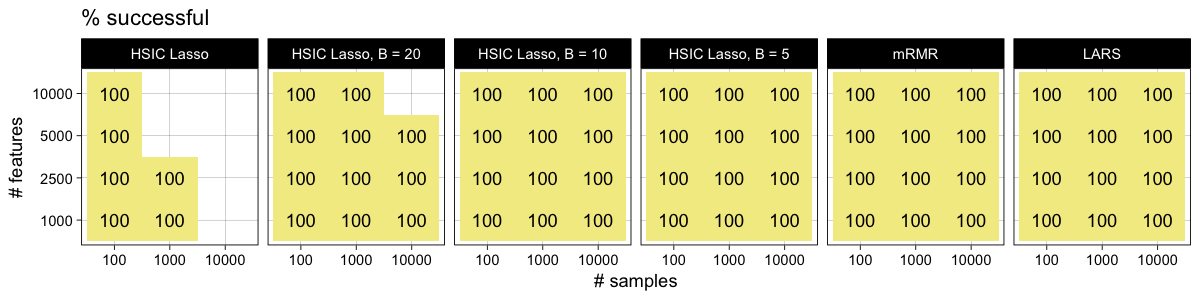

In [9]:
options(repr.plot.width=10, repr.plot.height=2.5)
features %>%
    group_by(model, samples, features) %>%
    summarize(ended = 100 * sum(ended)/sum(n),
              ended_txt = format(round(ended, 1), nsmall = 0)) %>%
    ggplot(aes(x = factor(samples), y = factor(features), fill = ended, label = ended_txt)) +
        geom_tile() +
        geom_text() +
        theme_linedraw() +
        facet_grid(. ~ model) +
        theme(legend.position = 'none') +
        labs(x = '# samples', y = '# features', title = '% successful') + 
        scale_fill_distiller(palette = "Spectral", direction = 1)

Computational resources were not tightly controlled, but we placed a a hard limit of 50GBs on memory consumption. When that memory was exceeded, jobs were killed. Above plot shows which jobs went over the limit. By using blocks, we are able to keep running HSIC Lasso in high dimensions.

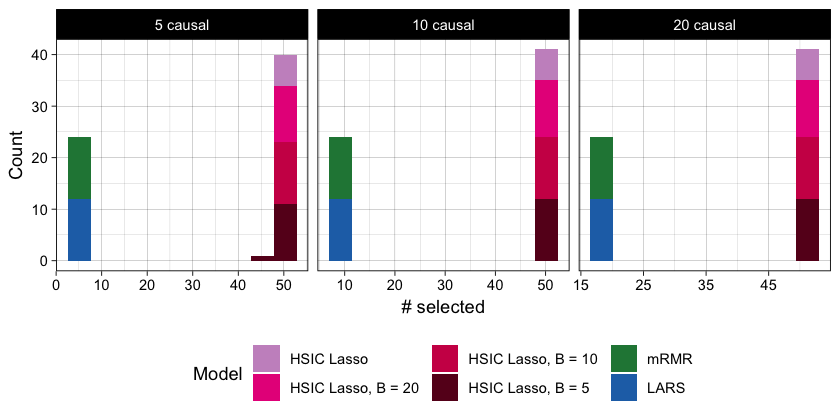

In [10]:
options(repr.plot.width=7, repr.plot.height=3.5)
ggplot(features, aes(selected, fill = model)) + 
    geom_histogram(bins = 10) + 
    facet_grid(. ~ causal_txt, scales = 'free') +
    labs(x = '# selected', y = 'Count', fill = 'Model') +
    theme_linedraw() +
    theme(legend.position = 'bottom') +
    scale_fill_manual(values = palette)

As a sanity check, we plot the number of features selected by each method in each setting. As we see, everything works as expected i.e. HSIC lasso selects 50 features, while mRMR and LARS selects the number of true causal features.

# Feature selection

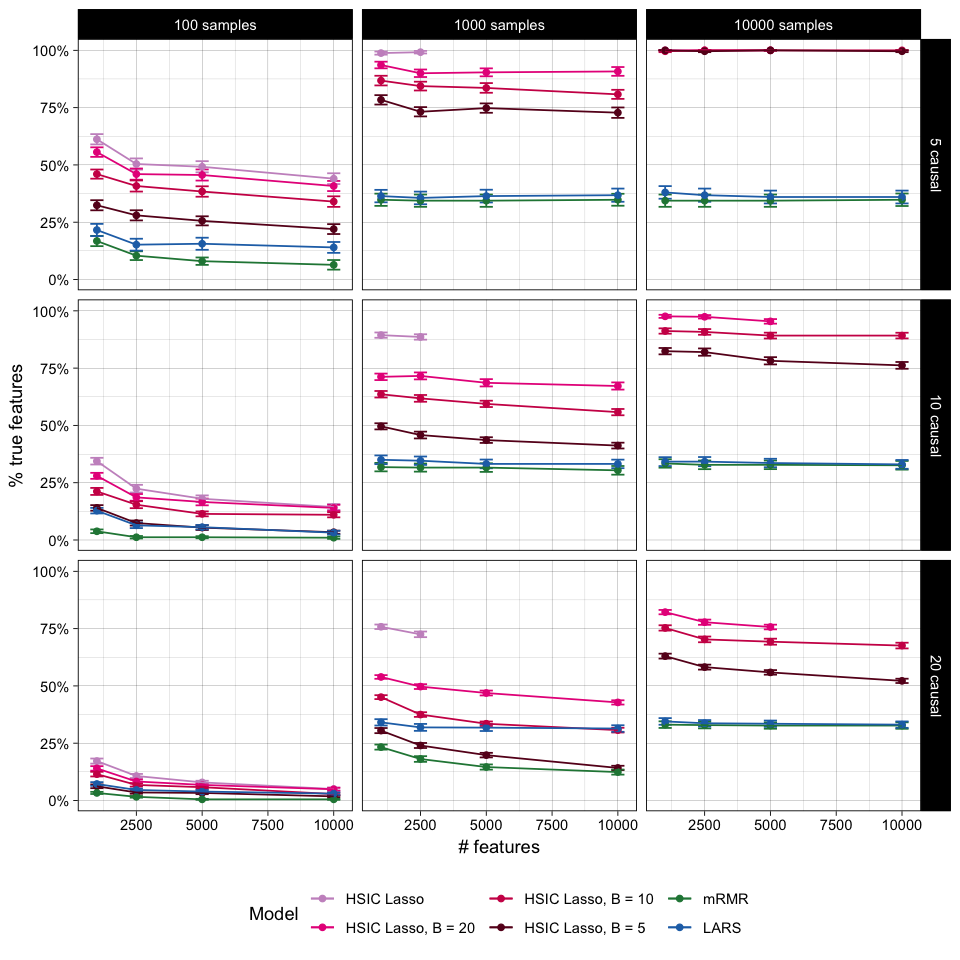

In [11]:
options(repr.plot.width=8, repr.plot.height=8)
ggplot(features, aes(x = features, y = tpr, color = model)) +
    geom_errorbar(aes(ymin = tpr - sem, ymax = tpr + sem), width = 500) +
    geom_point() +
    geom_line() +
    theme_linedraw() +
    theme(legend.position = 'bottom') +
    labs(x = '# features', y = '% true features', color = 'Model') +
    facet_grid(causal_txt ~ samples_txt) + 
    scale_y_continuous(labels = scales::percent) +
    scale_color_manual(values = palette)

Consistent with previous observations, HSIC Lasso performs better than mRMR, and decreasing block sizes perform worse.

# Prediction accuracy

We fitted a kernelized SVR to the features selected by mRMR and HSIC lasso. Then we measured the accuracy of the prediction as mean squared error (MSE) w.r.t. the output vector.

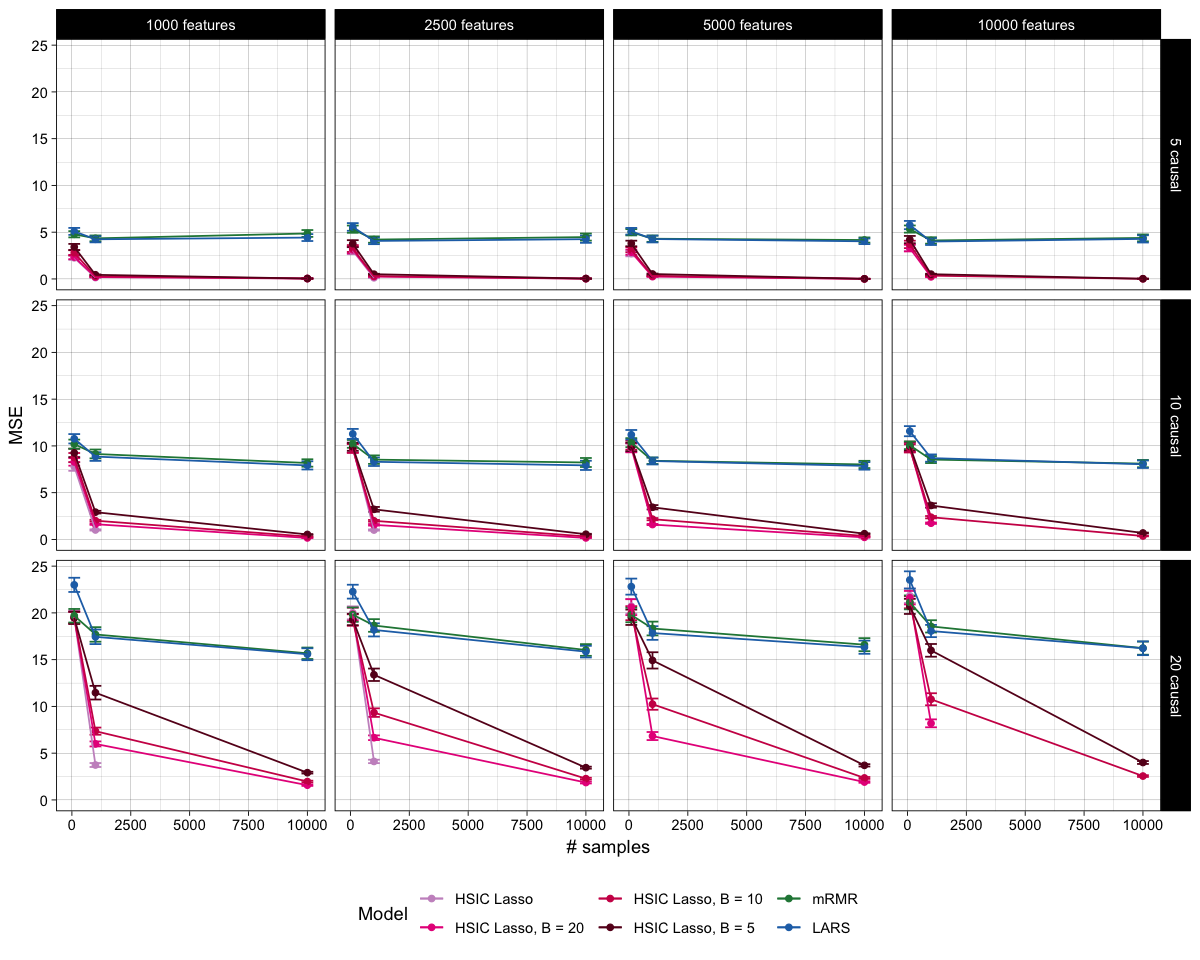

In [12]:
options(repr.plot.width=10, repr.plot.height=8)
prediction %>%
    ggplot(aes(x = samples, y = mse, color = model)) +
        geom_errorbar(aes(ymin = mse - sem, ymax = mse + sem), width = 500) +
        geom_point() +
        geom_line() +
        theme_linedraw() +
        theme(legend.position = 'bottom') +
        labs(x = '# samples', y = 'MSE', color = 'Model') +
        facet_grid(causal_txt ~ features_txt) +
        scale_color_manual(values = palette)

In accordance to previous plot, HSIC Lasso-based classifiers outperform other classifiers.